## Data Acquisition and Cleanup

Import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import requests
import numpy as np
import json
import os
import csv
from api_keys import geoapify_key

In [2]:
cities = {'Philadelphia':'PA',
         'Charlotte':'NC',
         'Nashville':'TN',
         'Portland':'OR',
         'Washington':'DC'}

Open and read the CSV Zillow File. Put the data into a pandas dataframe.

In [3]:
csvpath = os.path.join('Resources', 'zillowzipcodedata.csv')
with open(csvpath) as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    zillowdf = pd.DataFrame(csvreader)

Reduce to data for Phila, PA

In [17]:
phillyzillow = zillowdf.loc[(zillowdf[6] == 'Philadelphia')&(zillowdf[5] == 'PA'),(2,290)]
phillyzillow = phillyzillow.rename(columns={2:'zip_code',290:'ZHVI'})
phillyzillow = phillyzillow.set_index('zip_code')

Access the Philly crime API; import only crime data that has a valid zip code field.

In [18]:
philly_crime_url = 'https://phl.carto.com/api/v2/sql?q=SELECT * FROM arrests_zipcode'
philly_crime = requests.get(philly_crime_url).json()
philly_crime = pd.DataFrame(philly_crime['rows'])
philly_crime = philly_crime.loc[philly_crime['zip_code'] != 'Unknown','zip_code']

Count up incidents by zip code.

In [19]:
philly_crime_counts = pd.DataFrame(philly_crime.value_counts())
philly_crime_counts = philly_crime_counts.rename(columns={'zip_code':'offense_count'})

Access geoapify to convert zip codes to coordinates for map plot.

In [20]:
philly_crime_counts['lat'] = ''
philly_crime_counts['lon'] = ''
for index, row in philly_crime_counts.iterrows():
    zipcode = index
    zipcodeurl = f'https://api.geoapify.com/v1/geocode/search?text={zipcode}&lang=en&limit=10&type=postcode&filter=countrycode:us&apiKey={geoapify_key}'
    zipcodecoords = requests.get(zipcodeurl).json()
    try:
        lat = zipcodecoords['features'][0]['properties']['lat']
        lon = zipcodecoords['features'][0]['properties']['lon']
        philly_crime_counts.loc[index,'lat'] = lat
        philly_crime_counts.loc[index,'lon'] = lon
    except:
        print('Bad item')
        lat = ''
        lon = ''
        pass

Merge zillow and crime dataframes, using the zip codes as the index. Drop any rows without complete data (2 zip codes).

In [61]:
philly_combined = pd.merge(philly_crime_counts,phillyzillow,how='left', right_on = 'zip_code',left_index=True)
philly_combined = philly_combined.dropna()


Set color and size of each data point. Larger points have more crime. Redder points are zip codes with lower ZHVI scores; green are zip codes with better ZHVI scores.

In [62]:
philly_combined['ZHVI'] = philly_combined['ZHVI'].astype('float')
philly_combined['color'] = ''
philly_combined['size'] = 0

for index,row in philly_combined.iterrows():
    philly_combined['size'] = philly_combined['offense_count']/10
    if (philly_combined.loc[index,'ZHVI'] < 70000.):
        philly_combined.loc[index,'color'] = '#790909'
    elif (philly_combined.loc[index,'ZHVI'] >= 70000.)&(philly_combined.loc[index,'ZHVI'] < 125000.):
        philly_combined.loc[index,'color'] = '#793e09'
    elif (philly_combined.loc[index,'ZHVI'] >= 125000.)&(philly_combined.loc[index,'ZHVI'] < 200000.):
        philly_combined.loc[index,'color'] = '#795d09'
    elif (philly_combined.loc[index,'ZHVI'] >= 200000.)&(philly_combined.loc[index,'ZHVI'] < 300000.):
        philly_combined.loc[index,'color'] = '#797309'
    elif (philly_combined.loc[index,'ZHVI'] >= 300000.)&(philly_combined.loc[index,'ZHVI'] < 400000.):
        philly_combined.loc[index,'color'] = '#5b7909'
    elif (philly_combined.loc[index,'ZHVI'] >= 400000.)&(philly_combined.loc[index,'ZHVI'] < 500000.):
        philly_combined.loc[index,'color'] = '#127909'
    elif (philly_combined.loc[index,'ZHVI'] > 500000.):
        philly_combined.loc[index,'color'] = 'pink'

Produce the map.

In [57]:
themap = philly_combined.hvplot.points("lon","lat",
                                       geo = True,tiles = "CartoDark",
                                       frame_width = 750,frame_height = 600, 
                                       size = 'size',color='color', 
                                       hover_cols=['zip_code','offense_count','ZHVI'])

In [59]:
themap

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (color,size,zip_code,offense_count,ZHVI)

Determine the top and bottom zip codes at the final timepoint.

In [50]:
topzips = philly_combined.sort_values(by='ZHVI',ascending=False)
topzips.head()
top = ['19118','19103','19123','19147','19130']
topzips.tail()
bot = ['19142','19134','19140','19132','19133']

In [51]:
timepoints = list(zillowdf.loc[0,9:290])

Plotting the ZHVI as a function of time for the top and bottom 5 zips.

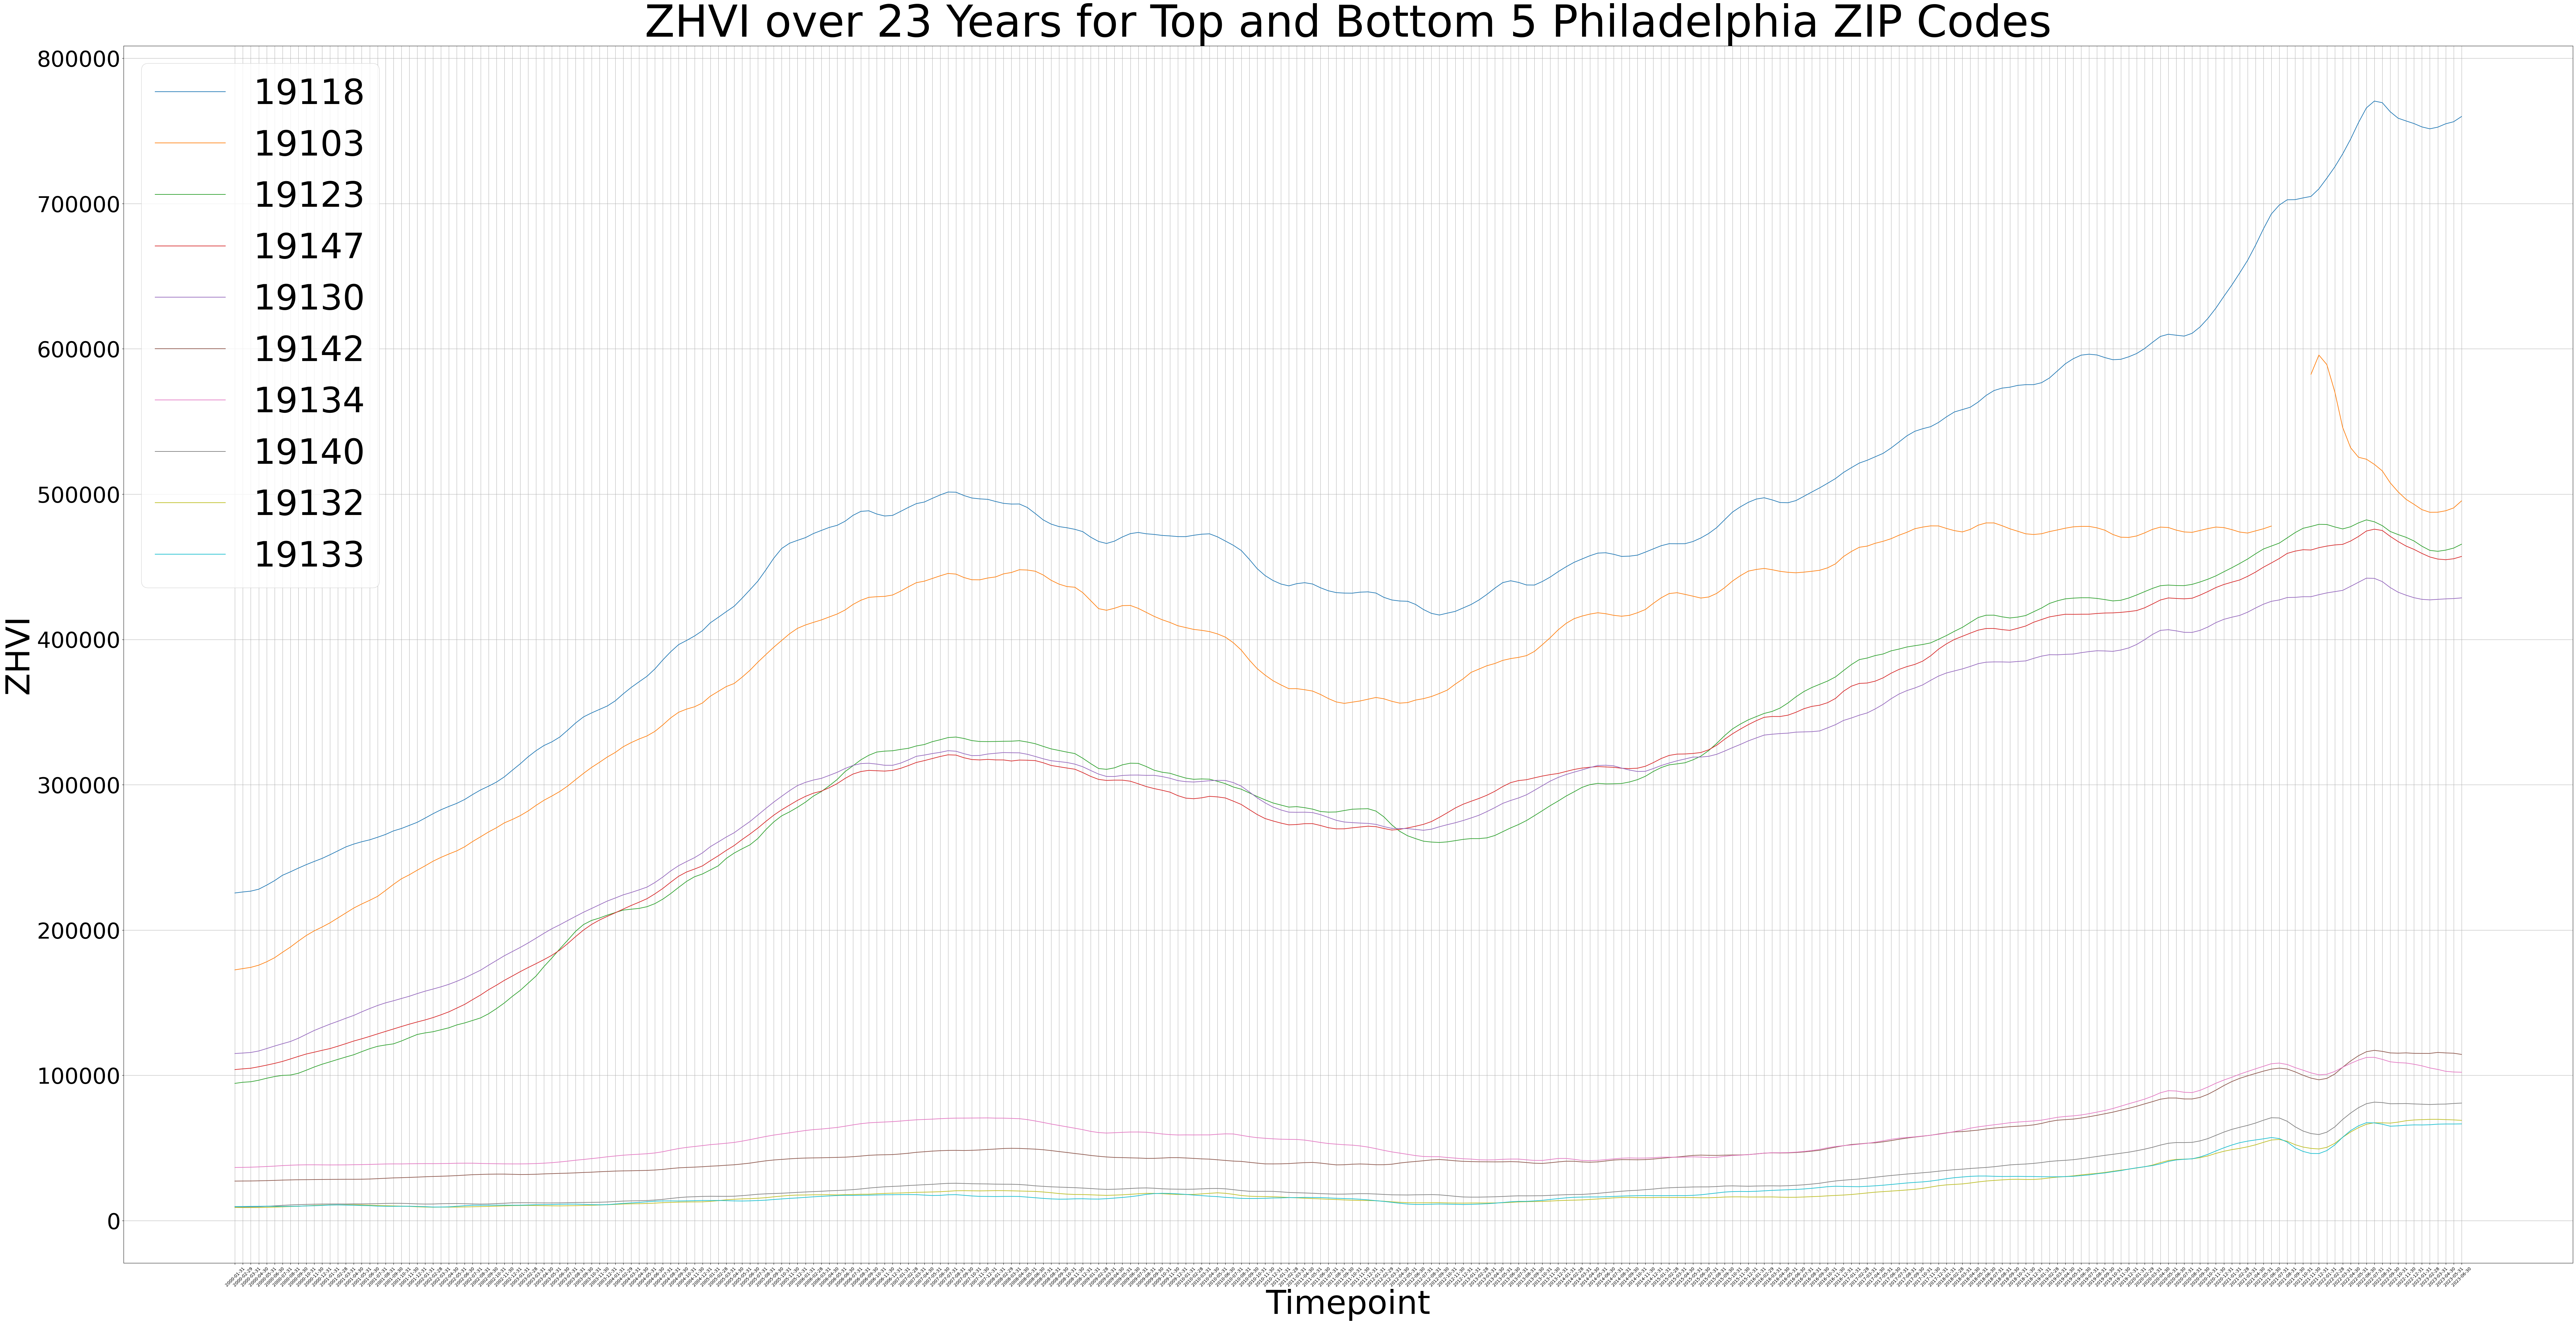

In [54]:
timezillow = zillowdf.loc[(zillowdf[6] == 'Philadelphia')&(zillowdf[5] == 'PA'),2:]

timezillow.replace('','NaN',inplace=True)
timezillow = timezillow.dropna()
timezillow = timezillow.rename(columns={2:'zip_code'})
timezillow = timezillow.set_index('zip_code')
timezillowtop,timezillowbot = timezillow.loc[top,9:],timezillow.loc[bot,9:]
timezillowtop,timezillowbot = timezillowtop.astype('float'),timezillowbot.astype('float')
timezillowtop,timezillowbot = timezillowtop.T,timezillowbot.T
timezillowtop,timezillowbot = timezillowtop.reset_index(drop=True),timezillowbot.reset_index(drop=True)


plt.figure(figsize=(100,50))
plt.plot(timezillowtop)
plt.plot(timezillowbot)
plt.title('ZHVI over 23 Years for Top and Bottom 5 Philadelphia ZIP Codes',fontsize=100)
plt.grid()
plt.legend(top+bot,fontsize=80)
plt.xlabel('Timepoint',fontsize=75)
plt.xticks(range(0,282),timepoints,rotation=45)
plt.yticks(fontsize=50)
plt.ylabel('ZHVI',fontsize=75)

plt.savefig('zhvi_vs_time')
plt.show()
